# Linear elasticity problem

We start by importing the necessary libraries.

In [167]:
# ----------------------------------------------------
# Essential Imports for FEniCSx Simulation
# ----------------------------------------------------

# NumPy: numerical operations, array manipulation
import numpy as np

# UFL: symbolic math language for defining weak forms
from ufl import (
    grad,                  # Gradient operator
    sym,                   # Symmetric part of tensor
    Identity,              # Identity tensor
    tr,                    # Trace of a tensor
    inner,                 # Inner product (dot product or double contraction)
    Measure,               # For defining integration domains (dx, ds)
    TestFunction,          # Virtual test function (v)
    TrialFunction          # Unknown trial function (u)
)

# MPI: parallel computing support (used internally by dolfinx)
from mpi4py import MPI

# FEniCSx core modules
from dolfinx import fem, io                          # FEM tools and I/O for XDMF, VTK, etc.
import dolfinx.fem.petsc                             # PETSc-based solvers (linear/nonlinear)
from dolfinx.mesh import create_rectangle, CellType  # Mesh generation and cell types

Now, we define the problem. It is a rectangular beam of dimensions $10 \times 1$ that we will mesh using quadrilateral elements.

In [168]:
# ----------------------------------------------------
# Define Physical Dimensions of the Domain
# ----------------------------------------------------

length, height = 10, 1.0   # Length and height of the rectangular domain (in user-defined units)

# ----------------------------------------------------
# Set Mesh Resolution (Number of Elements)
# ----------------------------------------------------

Nx, Ny = 200, 40             # Number of elements in x- and y-directions

# ----------------------------------------------------
# Create a Structured Rectangular Mesh
# ----------------------------------------------------

domain = create_rectangle(
    MPI.COMM_WORLD,                         # MPI communicator (parallel execution support)
    [np.array([0, 0]), np.array([length, height])],  # Lower-left and upper-right corners of the rectangle
    [Nx, Ny],                               # Number of cells (elements) in x and y
    cell_type=CellType.quadrilateral        # Use structured quadrilateral elements (not triangles)
)

# ----------------------------------------------------
# Get Mesh Dimension
# ----------------------------------------------------

dim = domain.topology.dim                  # Topological dimension of the mesh (2 for 2D)
print(f"Mesh topology dimension d={dim}.") # Print: "Mesh topology dimension d=2."

Mesh topology dimension d=2.


We now define a vector-valued finite element space using Lagrange elements of degree 1 for the displacement field. The function space V represents 2D vector fields (u_x, u_y). The solution function u_sol is initialized to store the computed displacements.

In [169]:
degree = 1
# Polynomial degree of the finite element basis functions
# "P" means Lagrange elements; degree 2 = quadratic

shape = (dim,)
# Specifies the shape of the function:
# (dim,) makes it a vector field with `dim` components
# For 2D problems → shape = (2,) → 2D vector-valued

V = fem.functionspace(domain, ("P", degree, shape))
# Define a vector-valued function space over the mesh `domain`
# Using continuous Lagrange ("P") elements of the specified degree
# Used for displacement, velocity, etc.

u_sol = fem.Function(V, name="Displacement")
# Create a finite element function in space V
# This will store the computed solution (e.g. displacement)
# `name="Displacement"` is useful for output visualization (e.g. in Paraview)


We now define the various UFL expressions which will enter our variational formulation.

In [170]:
# ----------------------------------------------------
# Linear Elasticity: Material Model Setup
# ----------------------------------------------------

# Material constants
E = fem.Constant(domain, 210e3)  # Young's modulus (e.g., in MPa)
nu = fem.Constant(domain, 0.3)   # Poisson's ratio

# Lamé parameters (for isotropic linear elasticity)
lmbda = E * nu / ((1 + nu) * (1 - 2 * nu))  # First Lamé parameter
mu = E / (2 * (1 + nu))                     # Shear modulus (second Lamé parameter)

# Strain tensor: ε(v) = ½(∇v + ∇vᵀ)
def epsilon(v):
    return sym(grad(v))

# Stress tensor: σ(v) = λ tr(ε(v)) I + 2μ ε(v)
def sigma(v):
    return lmbda * tr(epsilon(v)) * Identity(dim) + 2 * mu * epsilon(v)


We define the trial and test functions for the variational formulation. The body force is set as a constant downward force. The bilinear form a represents the stiffness matrix, and the linear form L represents the external force contribution. Integration is carried out over the domain.

In [171]:
# ----------------------------------------------------
# Linear Elasticity Weak Form
# ----------------------------------------------------

# Trial and test functions for variational formulation
u = TrialFunction(V)  # Unknown displacement field
v = TestFunction(V)   # Test (virtual displacement) function

# Body force (e.g., gravity acting in -y direction)
rho = 2e-3                              # Material density
g = 9.81                                # Gravity acceleration
# f = fem.Constant(domain, np.array([0, -rho * g]))  # Constant body force vector
f = fem.Constant(domain, np.array([0.0, -13.44]))

# Define integration measure over the domain
dx = Measure("dx", domain=domain)

# Weak form: bilinear form (stiffness) and linear form (external forces)
a = inner(sigma(u), epsilon(v)) * dx   # Left-hand side (stiffness matrix)
L = inner(f, v) * dx                   # Right-hand side (load vector)

We can now define the boundary conditions

In [172]:
# ----------------------------------------------------
# Dirichlet Boundary Conditions
# ----------------------------------------------------

# Define geometric conditions for the left and right edges
def left(x):
    return np.isclose(x[0], 0)               # Left edge: x = 0

def right(x):
    return np.isclose(x[0], length)          # Right edge: x = length

# Locate degrees of freedom on the specified boundaries
left_dofs = fem.locate_dofs_geometrical(V, left)
right_dofs = fem.locate_dofs_geometrical(V, right)

# Apply zero displacement (u = [0, 0]) on both edges
bcs = [
    fem.dirichletbc(np.zeros((2,)), left_dofs, V),
    fem.dirichletbc(np.zeros((2,)), right_dofs, V),
]

We define and solve the linear variational problem for displacement. A direct LU solver is used through PETSc. The computed displacement field is saved to a VTK file for visualization.

In [173]:
# ----------------------------------------------------
# Solve the Linear System and Write Output (One Cell)
# ----------------------------------------------------

# Define and solve the linear variational problem: A u = b
problem = fem.petsc.LinearProblem(
    a,                         # Bilinear form (stiffness)
    L,                         # Linear form (load)
    u=u_sol,                   # Function to store the solution
    bcs=bcs,                   # Dirichlet boundary conditions
    petsc_options={            # PETSc solver options
        "ksp_type": "preonly", # Use direct solver (no Krylov iterations)
        "pc_type": "lu"        # LU factorization (exact solve)
    }
)
problem.solve()                # Solve the system

# Save the solution to a VTK file for visualization (e.g., in ParaView)
vtk = io.VTKFile(domain.comm, "linear_elasticity.pvd", "w")
vtk.write_function(u_sol)     # Write the displacement field
vtk.close()                   # Close the file properly

## Verify with analytical solution

After solving, we extract the degrees of freedom coordinates and solution values.

In [174]:
# After solving

# Get DoF coordinates
coords = V.tabulate_dof_coordinates()  # (num_dofs, 2)

# Get solution values
u_array = u_sol.x.array

# Identify Y-component DoFs
is_y_component = np.arange(len(u_array)) % 2 == 1

# Get Y displacements
y_displacements = u_array[is_y_component]

# Find maximum and minimum Y displacement
max_y = np.max(y_displacements)
min_y = np.min(y_displacements)

print(f"Maximum upward vertical displacement (Y) = {max_y:.6e}")
print(f"Maximum downward vertical displacement (Y) = {min_y:.6e}")


Maximum upward vertical displacement (Y) = 0.000000e+00
Maximum downward vertical displacement (Y) = -2.047819e-02


Displacement of roughly -0.02 agrees well with analytical solution of clamped-clamped beam under uniform loading where

$$
\delta_{\text{max}} = \frac{q L^4}{384 E I}
$$

Substituting the known values:

$$
\delta_{\text{max}} = \frac{13.44 \times 10^4}{384 \times 210000 \times 0.083333} = 0.02
$$

## Mesh refinement

Here, we plot the displacement got using different element sizes. The values were obtained by running the code several times and recording the values.

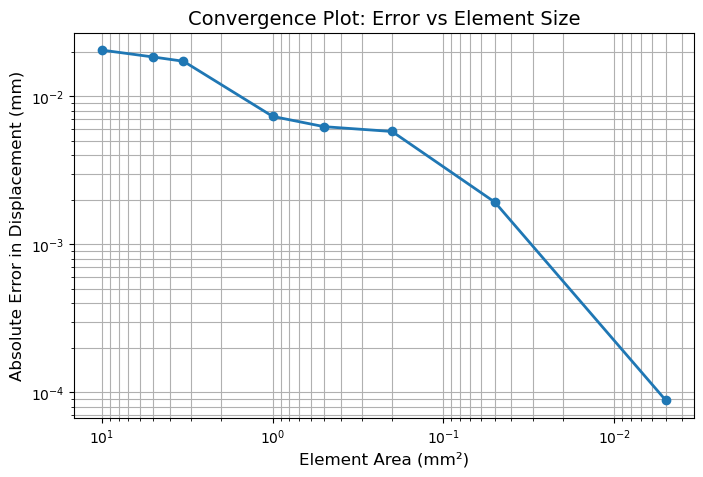

In [175]:
import matplotlib.pyplot as plt

# Given data
data = np.array([
    [1, 1, 0],
        [2, 1, -2.080000e-03],
    [3, 1, -3.254888e-03],
    [10, 1, -1.317333e-02],
    [10, 2, -1.425035e-02],
    [10, 5, -1.470030e-02],
    [20, 10, -1.855412e-02],
    [100, 20, -2.038957e-02],
])

length = 10
height = 1

Nx = data[:, 0]
Ny = data[:, 1]
displacement = data[:, 2]

# Element area
element_area = (length * height) / (Nx * Ny)

# Assume finest mesh result is "exact"
displacement_exact = -2.047819e-02

# Compute absolute error
error = np.abs(displacement - displacement_exact)

# Plot error vs element size
plt.figure(figsize=(8, 5))
plt.loglog(element_area, error, 'o-', linewidth=2)
plt.xlabel("Element Area (mm²)", fontsize=12)
plt.ylabel("Absolute Error in Displacement (mm)", fontsize=12)
plt.title("Convergence Plot: Error vs Element Size", fontsize=14)
plt.grid(True, which="both")
plt.gca().invert_xaxis()
plt.show()


## Code Failure

Code fails when the mesh is not refined enough. This is evident from above plot.